# Práctica 4: Procesamiento del Lenguaje Natural

__Fecha de entrega: 14 de mayo de 2024__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

__GRUPO: 11__

Alejandro Barrachina Argudo

Jaime Benedí Galdeano

In [1]:
RANDOM_STATE = 1234

# 1) Carga del conjunto de datos

El fichero `spam.csv` contiene mensajes SMS etiquetados como spam or ham (legítimo).

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 60% para entrenamiento, 20% para validación y el 20% restante para test. Comprueba que la distribución de los ejemplos en las particiones es similar. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

In [3]:
csv_data = 'spam.csv'
data = pd.read_csv(csv_data, encoding='latin-1')

In [4]:
import nltk
import numpy as np

wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
def preprocess_data(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

vec_preprocess_data = np.vectorize(preprocess_data)

data['v2'] = vec_preprocess_data(data['v2'])
spam = data[data['v1'] == 'spam']
ham = data[data['v1'] == 'ham']

[nltk_data] Downloading package stopwords to /home/_alk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
spam.iloc[0]['v2']

'free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply overs'

In [6]:
ham.iloc[0]['v2']

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['v2'], data['v1'], test_size=0.4, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)

<Axes: title={'center': 'Training set'}, ylabel='count'>

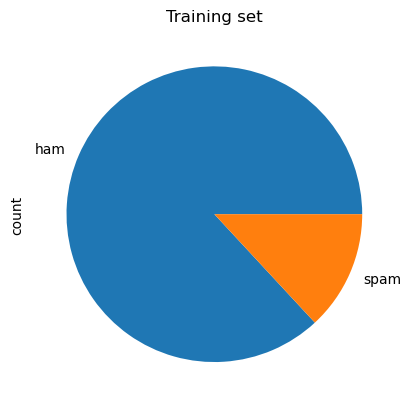

In [8]:
y_train.value_counts().plot(kind='pie', title='Training set')

<Axes: title={'center': 'Test set'}, ylabel='count'>

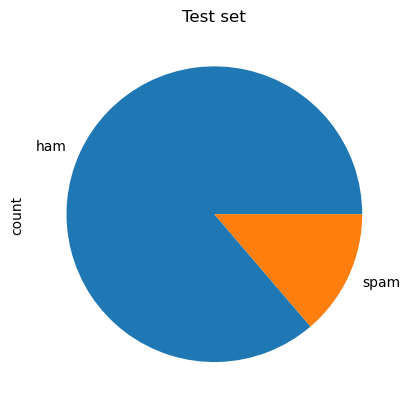

In [9]:
y_test.value_counts().plot(kind='pie', title='Test set')

<Axes: title={'center': 'Validation set'}, ylabel='count'>

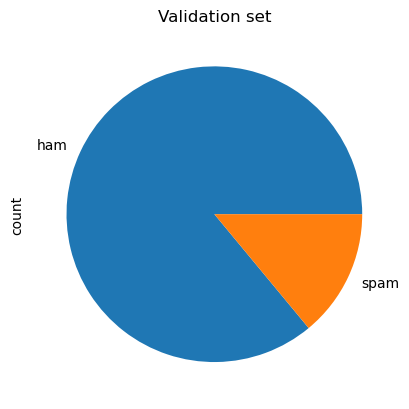

In [10]:
y_val.value_counts().plot(kind='pie', title='Validation set')

In [11]:
# Contamos las palabras que hay en el conjunto de datos
from collections import Counter

count_vectorizer_with_stopwords = Counter()
count_vectorizer_without_stopwords = Counter()
count_vectorizer_with_stopwords.update(' '.join(data['v2']).split())
count_vectorizer_without_stopwords.update(' '.join(data['v2']).split())

In [12]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

for word in stopwords:
    count_vectorizer_without_stopwords.pop(word, None)


[nltk_data] Downloading package stopwords to /home/_alk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
count_vectorizer_list = [(c,v) for (c,v) in count_vectorizer_with_stopwords.items() if len(c) > 3] 
print(len(count_vectorizer_list))
count_vectorizer_list.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_list

7436


[('call', 579),
 ('dont', 290),
 ('free', 278),
 ('ltgt', 276),
 ('know', 257),
 ('like', 242),
 ('good', 234),
 ('come', 226),
 ('time', 208),
 ('love', 195),
 ('want', 192),
 ('send', 190),
 ('text', 189),
 ('going', 171),
 ('need', 166),
 ('home', 162),
 ('sorry', 156),
 ('still', 153),
 ('stop', 153),
 ('back', 152),
 ('reply', 144),
 ('today', 141),
 ('mobile', 139),
 ('tell', 137),
 ('well', 134),
 ('later', 134),
 ('think', 132),
 ('please', 130),
 ('take', 126),
 ('phone', 126),
 ('cant', 125),
 ('week', 116),
 ('claim', 113),
 ('much', 113),
 ('night', 113),
 ('dear', 113),
 ('great', 111),
 ('happy', 106),
 ('hope', 103),
 ('make', 101),
 ('thats', 101),
 ('give', 100),
 ('work', 99),
 ('number', 94),
 ('prize', 92),
 ('right', 92),
 ('already', 90),
 ('tomorrow', 90),
 ('really', 86),
 ('yeah', 86),
 ('said', 86),
 ('message', 83),
 ('didnt', 83),
 ('meet', 78),
 ('babe', 78),
 ('last', 78),
 ('morning', 77),
 ('life', 77),
 ('miss', 76),
 ('thanks', 76),
 ('would', 76),
 ('

In [14]:
count_vectorizer_list = [(c,v) for (c,v) in count_vectorizer_without_stopwords.items() if len(c) > 3] 
print(len(count_vectorizer_list))
count_vectorizer_list.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_list

7436


[('call', 579),
 ('dont', 290),
 ('free', 278),
 ('ltgt', 276),
 ('know', 257),
 ('like', 242),
 ('good', 234),
 ('come', 226),
 ('time', 208),
 ('love', 195),
 ('want', 192),
 ('send', 190),
 ('text', 189),
 ('going', 171),
 ('need', 166),
 ('home', 162),
 ('sorry', 156),
 ('still', 153),
 ('stop', 153),
 ('back', 152),
 ('reply', 144),
 ('today', 141),
 ('mobile', 139),
 ('tell', 137),
 ('well', 134),
 ('later', 134),
 ('think', 132),
 ('please', 130),
 ('take', 126),
 ('phone', 126),
 ('cant', 125),
 ('week', 116),
 ('claim', 113),
 ('much', 113),
 ('night', 113),
 ('dear', 113),
 ('great', 111),
 ('happy', 106),
 ('hope', 103),
 ('make', 101),
 ('thats', 101),
 ('give', 100),
 ('work', 99),
 ('number', 94),
 ('prize', 92),
 ('right', 92),
 ('already', 90),
 ('tomorrow', 90),
 ('really', 86),
 ('yeah', 86),
 ('said', 86),
 ('message', 83),
 ('didnt', 83),
 ('meet', 78),
 ('babe', 78),
 ('last', 78),
 ('morning', 77),
 ('life', 77),
 ('miss', 76),
 ('thanks', 76),
 ('would', 76),
 ('

In [15]:
count_vectorizer_train_spam = Counter()
count_vectorizer_train_ham = Counter()
count_vectorizer_train_spam.update(' '.join(X_train[y_train == 'spam']).split())
count_vectorizer_train_ham.update(' '.join(X_train[y_train == 'ham']).split())

In [16]:
for words in stopwords:
    count_vectorizer_train_spam.pop(words, None)
    count_vectorizer_train_ham.pop(words, None)

In [17]:
count_vectorizer_train_spam = [(c,v)for (c,v) in count_vectorizer_train_spam.items() if len(c) > 3]
count_vectorizer_train_spam.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_train_spam

[('call', 213),
 ('free', 126),
 ('mobile', 79),
 ('text', 73),
 ('stop', 71),
 ('reply', 67),
 ('claim', 63),
 ('prize', 51),
 ('send', 42),
 ('service', 42),
 ('contact', 41),
 ('nokia', 40),
 ('cash', 39),
 ('urgent', 38),
 ('guaranteed', 32),
 ('phone', 31),
 ('please', 31),
 ('customer', 29),
 ('chat', 28),
 ('awarded', 25),
 ('line', 25),
 ('mins', 25),
 ('landline', 25),
 ('week', 25),
 ('camera', 23),
 ('tone', 23),
 ('live', 22),
 ('video', 21),
 ('message', 21),
 ('draw', 20),
 ('shows', 20),
 ('holiday', 20),
 ('number', 20),
 ('latest', 19),
 ('want', 18),
 ('receive', 18),
 ('offer', 17),
 ('award', 17),
 ('network', 17),
 ('attempt', 16),
 ('collection', 16),
 ('code', 16),
 ('ringtone', 16),
 ('every', 16),
 ('delivery', 15),
 ('bonus', 15),
 ('chance', 14),
 ('tones', 14),
 ('orange', 14),
 ('club', 14),
 ('back', 14),
 ('dating', 14),
 ('cost', 14),
 ('gift', 13),
 ('weekly', 13),
 ('find', 13),
 ('time', 13),
 ('apply', 13),
 ('land', 13),
 ('tried', 13),
 ('valid', 1

In [18]:
count_vectorizer_train_ham = [(c,v)for (c,v) in count_vectorizer_train_ham.items() if len(c) > 3]
count_vectorizer_train_ham.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_train_ham

[('ltgt', 179),
 ('dont', 157),
 ('know', 148),
 ('call', 146),
 ('like', 135),
 ('come', 134),
 ('good', 125),
 ('time', 110),
 ('love', 109),
 ('going', 108),
 ('home', 98),
 ('want', 97),
 ('sorry', 96),
 ('need', 91),
 ('tell', 86),
 ('send', 85),
 ('later', 85),
 ('still', 83),
 ('well', 77),
 ('think', 76),
 ('back', 75),
 ('take', 74),
 ('today', 70),
 ('much', 67),
 ('yeah', 64),
 ('thats', 64),
 ('cant', 64),
 ('great', 61),
 ('night', 60),
 ('hope', 55),
 ('give', 54),
 ('already', 53),
 ('said', 53),
 ('work', 52),
 ('dear', 51),
 ('make', 50),
 ('happy', 49),
 ('please', 49),
 ('didnt', 48),
 ('right', 48),
 ('morning', 47),
 ('text', 46),
 ('phone', 46),
 ('life', 46),
 ('sure', 45),
 ('meet', 44),
 ('miss', 44),
 ('really', 43),
 ('something', 43),
 ('also', 42),
 ('would', 42),
 ('last', 42),
 ('friends', 42),
 ('soon', 41),
 ('went', 41),
 ('around', 41),
 ('free', 41),
 ('tomorrow', 40),
 ('pick', 40),
 ('wait', 40),
 ('number', 40),
 ('sent', 39),
 ('many', 38),
 ('ni

# 2) Representación como bolsa de palabras

Elige justificadamente una representación de bolsa de palabras y aplícala.
Muestra un ejemplo antes y después de aplicar la representación. Explica los cambios.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_matrix = cv.fit_transform(X_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
vocab = cv.get_feature_names_out()

pd.DataFrame(cv_matrix, columns=vocab)

,aa,aaniye,aathilove,aathiwhere,ab,abdomen,abeg,aberdeen,abi,ability,...,zac,zealand,zed,zf,zindgi,zoe,zoom,zouk,zs,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X_train.iloc[27]

'mmm yummy babe nice jolt suzy'

In [22]:
cv_matrix[27]

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer()
tv_matrix = tv.fit_transform(X_train)
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,aa,aaniye,aathilove,aathiwhere,ab,abdomen,abeg,aberdeen,abi,ability,...,zac,zealand,zed,zf,zindgi,zoe,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix) 
similarity_df


,0,1,2,3,4,5,6,7,8,9,...,3333,3334,3335,3336,3337,3338,3339,3340,3341,3342
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.064652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.119640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.164103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3339,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3340,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3341,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# 3) Aplica 3 algoritmos de aprendizaje automático para resolver la tarea

Justifica porqué los has elegido.
Ajusta los modelos respecto a un hiperparámetro que consideres oportuno. Justifica tu elección.
Explica los resultados obtenidos.

In [25]:
from sklearn import tree
import numpy as np
train_preprocessed = tv.transform(X_train)
test_preprocessed = tv.transform(X_test)
cv_preprocessed = tv.transform(X_val)

# Creamos el clasificador con los valores por defecto
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_preprocessed, y_train)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)
tree_cv_predictions = tree_classifier.predict(cv_preprocessed)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))
print("Árbol, porcentaje de aciertos en validación:", np.mean(tree_cv_predictions == y_val))

Árbol, porcentaje de aciertos en entrenamiento: 1.0
Árbol, porcentaje de aciertos en test: 0.9452423698384201
Árbol, porcentaje de aciertos en validación: 0.9515695067264573


In [26]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, y_train)

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)
knn_cv_predictions = knn_classifier.predict(cv_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == y_train))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == y_test))
print("k-NN, porcentaje de aciertos en validación:", np.mean(knn_cv_predictions == y_val))

k-NN, porcentaje de aciertos en entrenamiento: 0.9210290158540233
k-NN, porcentaje de aciertos en test: 0.8976660682226212
k-NN, porcentaje de aciertos en validación: 0.9040358744394619


In [27]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, y_train)

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)
mnb_cv_predictions = mnb_classifier.predict(cv_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == y_test))
print("Multinomial Naive Bayes, porcentaje de aciertos en validación:", np.mean(mnb_cv_predictions == y_val))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9754711337122345
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9488330341113106
Multinomial Naive Bayes, porcentaje de aciertos en validación: 0.9533632286995516


El mejor parece Multinomial Naive Bayes ya que no sobreentrena en train y da los mejores valores en test y cv

# 4) Construye redes neuronales con Keras con distintas maneras de usar word embeddings

Justifica tus decisiones y explica los resultados obtenidos.

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_words = 1500
max_comment_length = 20

csv_data = 'spam.csv'
df = pd.read_csv(csv_data, encoding='latin-1')

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.v2)

sequences = tokenizer.texts_to_sequences(df.v2)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_words = len(word_index)

data = pad_sequences(sequences, maxlen=max_comment_length)

2024-05-03 19:45:50.150815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 8916 unique tokens.


In [29]:
labels = df.v1.to_numpy()
def transform_label(x):
    return 1 if x == 'spam' else 0
labels = np.array([transform_label(x) for x in labels])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)

In [31]:

embedding_dim = 50

In [32]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 500  77
 115 132]


In [33]:
print(y_train[0])

0


In [34]:
# MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model1 = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs


model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
# After the Embedding layer, our activations have shape `(max_words, max_comment_length, embedding_dim)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(max_words, max_comment_length * embedding_dim)`

model1.add(Flatten())

# We add the classifier on top
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

score1 = model1.evaluate(X_test, y_test)

print("Accuracy: %.2f%%" % (score1[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            445800    
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 446,801
Trainable params: 446,801
Non-trainable params: 0
_________________________________________________________________


2024-05-03 19:45:52.142520: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/20
105/105 [==============================] - 1s 8ms/step - loss: 0.3531 - accuracy: 0.9100 - val_loss: 0.1974 - val_accuracy: 0.9443
Epoch 2/20
105/105 [==============================] - 1s 6ms/step - loss: 0.1218 - accuracy: 0.9677 - val_loss: 0.1047 - val_accuracy: 0.9713
Epoch 3/20
105/105 [==============================] - 1s 6ms/step - loss: 0.0628 - accuracy: 0.9835 - val_loss: 0.0724 - val_accuracy: 0.9811
Epoch 4/20
105/105 [==============================] - 1s 6ms/step - loss: 0.0403 - accuracy: 0.9895 - val_loss: 0.0619 - val_accuracy: 0.9811
Epoch 5/20
105/105 [==============================] - 1s 6ms/step - loss: 0.0288 - accuracy: 0.9940 - val_loss: 0.0575 - val_accuracy: 0.9838
Epoch 6/20
105/105 [==============================] - 1s 6ms/step - loss: 0.0213 - accuracy: 0.9961 - val_loss: 0.0534 - val_accuracy: 0.9838
Epoch 7/20
105/105 [==============================] - 1s 6ms/step - loss: 0.0168 - accuracy: 0.9967 - val_loss: 0.0524 - val_accuracy: 0.9838
Epoch 

In [35]:
import os
import numpy as np

glove_dir = './'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [36]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [37]:
# MODELO 2. EMBEDDINGS PRE-ENTRENADOS CONGELADOS

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 50)            445800    
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 446,801
Trainable params: 446,801
Non-trainable params: 0
_________________________________________________________________


In [38]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

In [39]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

score2 = model2.evaluate(X_test, y_test)

Epoch 1/20


105/105 [==============================] - 1s 3ms/step - loss: 0.4038 - accuracy: 0.8229 - val_loss: 0.2264 - val_accuracy: 0.9345
Epoch 2/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.9483 - val_loss: 0.1779 - val_accuracy: 0.9506
Epoch 3/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.9599 - val_loss: 0.1593 - val_accuracy: 0.9515
Epoch 4/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1192 - accuracy: 0.9635 - val_loss: 0.1468 - val_accuracy: 0.9542
Epoch 5/20
105/105 [==============================] - 0s 2ms/step - loss: 0.1058 - accuracy: 0.9671 - val_loss: 0.1410 - val_accuracy: 0.9551
Epoch 6/20
105/105 [==============================] - 0s 2ms/step - loss: 0.0966 - accuracy: 0.9716 - val_loss: 0.1346 - val_accuracy: 0.9560
Epoch 7/20
105/105 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.9731 - val_loss: 0.1279 - val_accuracy: 0.9614
Epoch 8/20
105/10

Accuracy del 96.77%

In [40]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model3.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

score3 = model3.evaluate(X_test, y_test)

print("Accuracy: %.2f%%" % (score3[1]*100))

Model: "sequential_2"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 50)            445800    
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 446,801
Trainable params: 446,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
105/105 [==============================] - 2s 8ms/step - loss: 0.2756 - accuracy: 0.8977 - val_loss: 0.1718 - val_accuracy: 0.9390
Epoch 2/20
105/105 [==============================] - 1s 6ms/step - loss: 0.1179 - accuracy: 0.9647 - val_loss: 0.1269 - val_accuracy: 0.9614
Epoch 3/20
105/105 [==============================

In [41]:
print("Sin word embeddings pre-entrenados")
print("Accuracy: %.2f%%" % (score1[1]*100))
print("Con word embeddings pre-entrenados congelados")
print("Accuracy: %.2f%%" % (score2[1]*100))
print("Con word embeddings pre-entrenados sin congelar")
print("Accuracy: %.2f%%" % (score3[1]*100))

Sin word embeddings pre-entrenados
Accuracy: 98.29%
Con word embeddings pre-entrenados congelados
Accuracy: 96.77%
Con word embeddings pre-entrenados sin congelar
Accuracy: 98.03%


# 5) Aplica los modelos construidos a los datos de test y compáralos.

Calcula las métricas de recall, precisión y f1.
Discute cual es el mejor modelo y cual es peor y porqué.

In [65]:
def plot_confusion_matrix(y: np.ndarray, p: np.ndarray, tags) -> None:
    """Plots the confusion matrix for a given prediction.

    Args:
        y (np.ndarray): expected values
        p (np.ndarray): predicted values
        filename (str): file to store the plot
    """
    fig, ax = plt.subplots()
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_xticks(np.arange(0,tags))
    ax.set_yticks(np.arange(0,tags))
    ax.set_ylabel("True")
    cm = np.zeros((tags, tags))
    for i in range(len(y)):
        cm[y[i] - 1][p[i] - 1] += 1
    cax = ax.matshow(cm, cmap='Reds')
    ax.set_xticks(np.arange(0, tags))
    ax.set_yticks(np.arange(0, tags))
    ax.set_yticks(np.arange(0.5, tags + 0.5), minor='True')
    ax.set_xticks(np.arange(0.5, tags + 0.5), minor='True')
    plt.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.5)
    fig.colorbar(cax)
    for (i, j), z in np.ndenumerate(cm):
        if i == j:
            ax.text(j, i, '{:0.1f}'.format(z),
                    ha='center', va='center', fontsize=8, color='white')
        else:
            ax.text(j, i, '{:0.1f}'.format(z),
                    ha='center', va='center', fontsize=8)
    plt.show()

              precision    recall  f1-score   support

         ham       0.96      0.98      0.97       961
        spam       0.84      0.74      0.79       153

    accuracy                           0.95      1114
   macro avg       0.90      0.86      0.88      1114
weighted avg       0.94      0.95      0.94      1114



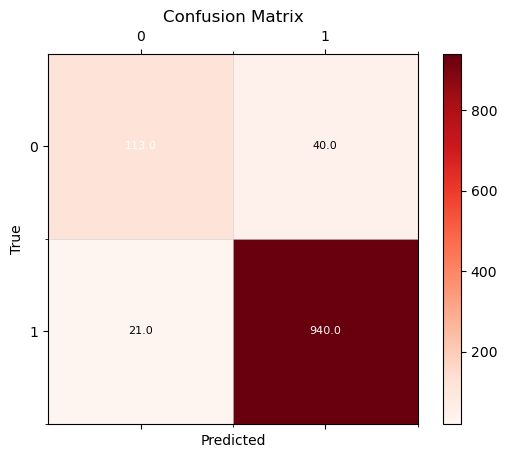

In [67]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions = [1 if x == 'spam' else 0 for x in tree_test_predictions]
print(classification_report(
    y_test, predictions, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions, len(target_names))

              precision    recall  f1-score   support

         ham       0.89      1.00      0.94       961
        spam       1.00      0.25      0.41       153

    accuracy                           0.90      1114
   macro avg       0.95      0.63      0.68      1114
weighted avg       0.91      0.90      0.87      1114



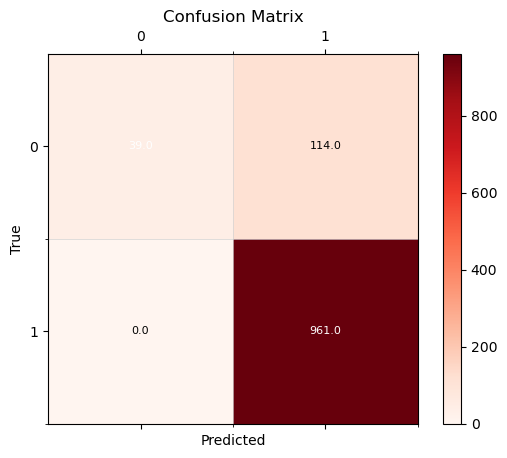

In [69]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions = [1 if x == 'spam' else 0 for x in knn_test_predictions]
print(classification_report(
    y_test, predictions, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions, len(target_names))

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       961
        spam       1.00      0.63      0.77       153

    accuracy                           0.95      1114
   macro avg       0.97      0.81      0.87      1114
weighted avg       0.95      0.95      0.94      1114



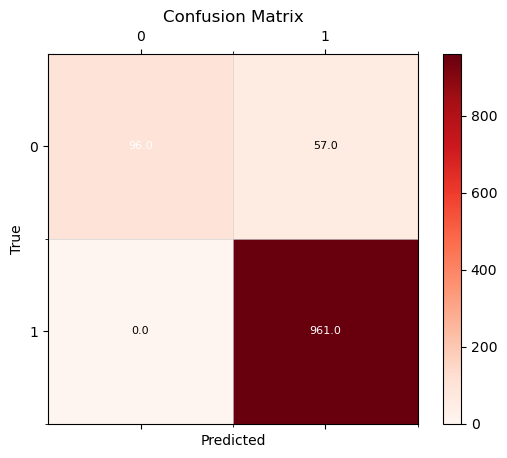

In [71]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions = [1 if x == 'spam' else 0 for x in mnb_test_predictions]
print(classification_report(
    y_test, predictions, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions, len(target_names))

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         ham       0.86      1.00      0.93       961
        spam       0.00      0.00      0.00       153

    accuracy                           0.86      1114
   macro avg       0.43      0.50      0.46      1114
weighted avg       0.74      0.86      0.80      1114



/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

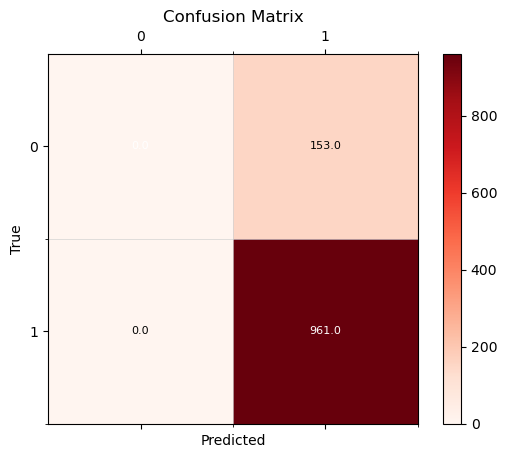

In [73]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions = [1 if x == 'spam' else 0 for x in np.argmax(model1.predict(X_test), axis=-1)]
print(classification_report(
    y_test, predictions, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions, len(target_names))

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         ham       0.86      1.00      0.93       961
        spam       0.00      0.00      0.00       153

    accuracy                           0.86      1114
   macro avg       0.43      0.50      0.46      1114
weighted avg       0.74      0.86      0.80      1114



/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

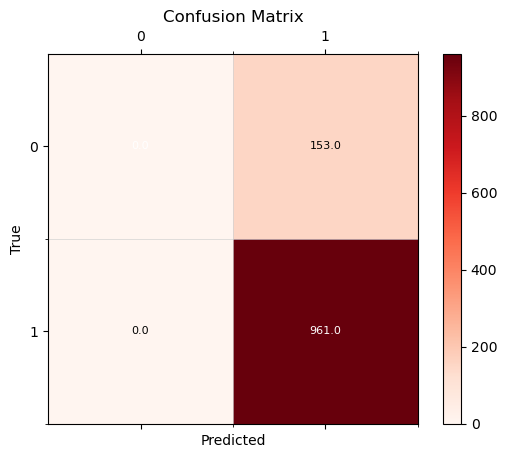

In [74]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions = [1 if x == 'spam' else 0 for x in np.argmax(model2.predict(X_test), axis=-1)]
print(classification_report(
    y_test, predictions, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions, len(target_names))

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         ham       0.86      1.00      0.93       961
        spam       0.00      0.00      0.00       153

    accuracy                           0.86      1114
   macro avg       0.43      0.50      0.46      1114
weighted avg       0.74      0.86      0.80      1114



/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/_alk/Documentos/uni/IA2/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

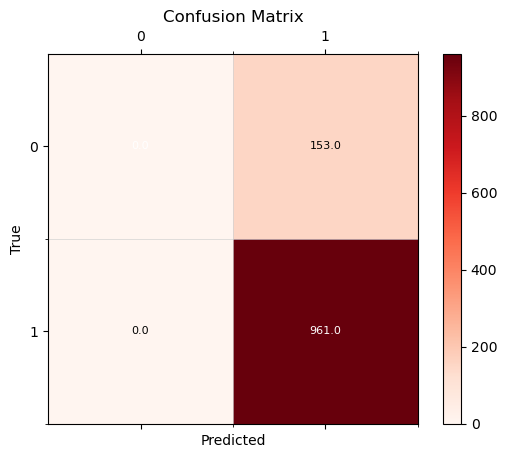

In [75]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
#En el output de esta celda se puede ver que las cantidades en support cuadran en categoría con las de arriba.

target_names = list(df["v1"].unique())

# creamos una variable auxiliar para las predicciones
predictions = [1 if x == 'spam' else 0 for x in np.argmax(model3.predict(X_test), axis=-1)]
print(classification_report(
    y_test, predictions, target_names=target_names))

# Dibuja la matriz de confusión.
# Analiza los resultados obtenidos.
#------------------------------------------------------------------------------


# creamos la matriz de confusion
conf_matrix = plot_confusion_matrix(y_test, predictions, len(target_names))